# 02 – Autencoder adventures, different approach

In this version, instead of feeding the autoencoder with very high dimensional documents, we represent them by the sum and the mean of their vectors. As we can see below, the general classification scores went up for all the methods, and especially for the autoencoder which is now closer to the other methods.

## Imports

In [1]:
import helpers # some general functions for loading, writting and plotting stuff
import re
import pandas as pd
import numpy as np

In [2]:
from keras.layers import Input, Dense, Embedding, Flatten
from keras import regularizers
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, Tokenizer

C:\Users\Thibault\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize

## Some constants

I decided to go with 32 as the dimension of the latent space since it gave the best classification results afterwards. I believe in concrete work this would greatly depend on the task.

In [129]:
LATENT_SPACE_DIM = 32
MAX_WORDS = 1_000

## Data preparation

### Load data

In [92]:
full_data = helpers.most_recent_dataset()

In [93]:
# change this to vary subset size for testing
data = full_data.sample(int(len(full_data) * 1))

### Labels

In [94]:
le = preprocessing.LabelEncoder()
le.fit(data['label'])
y = le.transform(data['label'])

### Embedding

Here we use a simple word2vec style approach. GloVe pretrained vectors could ameliorate the results.

In [95]:
docs = data['content']

In [96]:
%%time
tk = Tokenizer()
tk.fit_on_texts(docs)

Wall time: 14.7 s


In [97]:
%%time
tk.num_words = MAX_WORDS
docs_seq = tk.texts_to_sequences(docs)

Wall time: 11.5 s


In [98]:
%%time
pad_len = int(pd.DataFrame([len(e) for e in docs_seq]).max())
X_padded = pad_sequences(docs_seq, maxlen=pad_len, padding='post')

Wall time: 1.86 s


In [99]:
%%time
model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=32, input_length=pad_len))
model.compile('rmsprop', 'mse')

X_full = model.predict(X_padded)

C:\Users\Thibault\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
C:\Users\Thibault\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Wall time: 39.1 s


In [100]:
X_full.shape

(8000, 19657, 32)

In [101]:
%%time
X_sum = np.sum(X_full, axis=1)

Wall time: 40.5 s


In [115]:
%%time
X_median = np.median(X_full, axis=1)

Wall time: 2min 35s


In [103]:
%%time
X_mean = np.mean(X_full, axis=1)

Wall time: 40.4 s


In [116]:
%%time
X = np.concatenate((X_sum, X_mean), axis=1)
X = np.concatenate((X_mean, X), axis=1)

Wall time: 15.6 ms


In [117]:
X = preprocessing.normalize(X, axis=1)

In [118]:
X.shape

(8000, 96)

## Autoencoder

The actual autoencoder. I chosed to keep it shallow, without hidden layers, to iterate faster. Improvement on the architecture (ammount, type and size of the layers) would be at the core of further reaserch on this task.

In [155]:
input_dim = X.shape[1]
target_dim = LATENT_SPACE_DIM
activation_type = 'tanh' # tried 'relu', but 'tanh' performs better


### Architecture
input_text = Input(shape=(input_dim,))
encoded = Dense(64, activation=activation_type)(input_text)
#encoded = Dense(32, activation=activation_type)(encoded)
encoded_out = Dense(target_dim, activation=activation_type, 
                activity_regularizer=regularizers.l1(10e-5))(encoded) # constrain so that less neurons fire at the same time -> latent representations are sparser
# "latent space"
decoded = Dense(64, activation=activation_type)(encoded_out)
#decoded = Dense(64, activation=activation_type)(decoded)
decoded_out = Dense(input_dim, activation='sigmoid')(decoded)

### Autoencoder
autoencoder = Model(input_text, decoded_out)

### Encoder
encoder = Model(input_text, encoded_out)

C:\Users\Thibault\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
C:\Users\Thibault\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [156]:
# 'mse' performed better than 'binary_cross_entropy'
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder.summary()

C:\Users\Thibault\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 96)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                6208      
_________________________________________________________________
dense_56 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_57 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_58 (Dense)             (None, 96)                6240      
Total params: 16,640
Trainable params: 16,640
Non-trainable params: 0
_________________________________________________________________


In [157]:
%%time
# The autoencoder tries to fit the same value as its output than at its input
history = autoencoder.fit(X, X,
                epochs=50,
                batch_size=256,
                validation_split=.2,
                verbose=1)

C:\Users\Thibault\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
C:\Users\Thibault\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


Train on 6400 samples, validate on 1600 samples
Epoch 1/50
6400/6400 [==============================] - 1s 98us/step - loss: 0.2741 - acc: 0.0000e+00 - val_loss: 0.2497 - val_acc: 0.0000e+00
Epoch 2/50
6400/6400 [==============================] - 0s 20us/step - loss: 0.2334 - acc: 0.0000e+00 - val_loss: 0.2071 - val_acc: 0.0000e+00
Epoch 3/50
6400/6400 [==============================] - 0s 17us/step - loss: 0.1531 - acc: 3.1250e-04 - val_loss: 0.0968 - val_acc: 6.2500e-04
Epoch 4/50
6400/6400 [==============================] - 0s 17us/step - loss: 0.0789 - acc: 0.3200 - val_loss: 0.0621 - val_acc: 0.9969
Epoch 5/50
6400/6400 [==============================] - 0s 20us/step - loss: 0.0550 - acc: 0.9991 - val_loss: 0.0468 - val_acc: 0.9969
Epoch 6/50
6400/6400 [==============================] - 0s 17us/step - loss: 0.0434 - acc: 0.9991 - val_loss: 0.0387 - val_acc: 0.9969
Epoch 7/50
6400/6400 [==============================] - 0s 20us/step - loss: 0.0364 - acc: 0.9991 - val_loss: 0.0327 -

The graph below shows a pretty standard loss curve over epochs. The accuracy curve on the other hand was more puzzling to me, since both training and validation accuracy are stuck at zero. Wrapping my head around it, I believe its because the reconstruction of the sample is not precise in an autoencoder. We don’t have an easy yes/no answer like we would have with, say, a binary classifier. Thus the loss is the metric that is of actual interest to us.

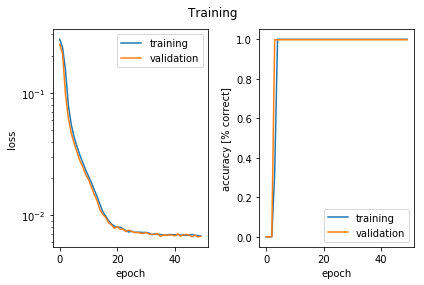

In [158]:
helpers.plot_history(history, 'Training');

## Classification

In [159]:
def classify_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    return clf.predict(X)

### “Raw” classifier

Before trying out our autoencoder, we simply try to classify our raw vectors.

In [167]:
y_raw = classify_and_evaluate(X, y)

             precision    recall  f1-score   support

  Economics       0.24      0.36      0.29       183
Linguistics       0.49      0.46      0.47       227
 Literature       0.27      0.31      0.29       189
       Math       0.50      0.49      0.50       194
    Oceania       0.48      0.38      0.42       216
   Politics       0.29      0.30      0.29       208
 Prehistory       0.40      0.38      0.39       182
   Religion       0.34      0.26      0.30       201

avg / total       0.38      0.37      0.37      1600



### PCA

For the comparison to be meaningful, we use the same dimensionality reduction as we did with the autoencoder.

In [166]:
X_pca = PCA(n_components=LATENT_SPACE_DIM).fit_transform(X)
y_pca = classify_and_evaluate(X_pca, y)

             precision    recall  f1-score   support

  Economics       0.30      0.49      0.37       192
Linguistics       0.50      0.51      0.50       215
 Literature       0.36      0.44      0.40       185
       Math       0.40      0.44      0.42       193
    Oceania       0.47      0.40      0.43       214
   Politics       0.37      0.28      0.32       203
 Prehistory       0.43      0.34      0.38       189
   Religion       0.37      0.25      0.30       209

avg / total       0.40      0.39      0.39      1600



### Latent space

Now we can classify our pages using there autoencoded versions to see what we get.

In [165]:
X_latent = encoder.predict(X)
y_latent = classify_and_evaluate(X_latent, y)

             precision    recall  f1-score   support

  Economics       0.29      0.38      0.33       207
Linguistics       0.43      0.50      0.46       203
 Literature       0.30      0.38      0.34       185
       Math       0.44      0.46      0.45       190
    Oceania       0.46      0.38      0.42       207
   Politics       0.33      0.27      0.30       188
 Prehistory       0.54      0.41      0.47       223
   Religion       0.38      0.34      0.36       197

avg / total       0.40      0.39      0.39      1600

